In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression


In [12]:
pyro = pd.read_csv("../sandbox/PyR0_Ranked_Strains.tsv", sep="\t")
pyro.rename(columns={"strain": "Strain",
                     "R / R_A": "Growth_Pyro",
                     "Run date": "Run_Date"},
            inplace=True)

pyro["Run_Date"] = pd.to_datetime(pyro["Run_Date"])
pyro["birthday"] = pd.to_datetime(pyro["birthday"])
bday = pyro[["Strain", "birthday"]].drop_duplicates().reset_index(drop=True)
pyro = pyro[pyro["Run_Date"]>=pyro["birthday"]].copy()
pyro = pyro[["Run_Date", "Strain", "Growth_Pyro"]]
#pyro["Rank_Pyro"] = pyro.groupby(["Run_Date"])["Growth_Pyro"].rank(ascending=False)
pyro

Run_Date  Strain  Growth_Pyro
378    2021-03-12  AY.130     2.321190
389    2021-03-12  AY.127     2.257260
406    2021-03-12  AY.126     2.157470
411    2021-03-12   AY.36     2.149650
414    2021-03-12  AY.121     2.141910
...           ...     ...          ...
122806 2024-01-04       A     1.000000
122807 2024-01-04       B     0.998377
122808 2024-01-04    B.33     0.997958
122809 2024-01-04   B.1.1     0.950037
122810 2024-01-04     B.1     0.934200

[115523 rows x 3 columns]

In [13]:

bvas = pd.read_csv("../sandbox/BVAS_Ranked_Strains.tsv", sep="\t")
bvas.rename(columns={"VariantName":"Strain",
                     "GrowthRate": "Growth_BVAS",
                     "Run date": "Run_Date"},
            inplace=True)
bvas = bvas.merge(bday, on="Strain", how="left")
bvas = bvas[bvas["Run_Date"]>=bvas["birthday"]].copy()

bvas = bvas[["Run_Date", "Strain", "Growth_BVAS"]].drop_duplicates().reset_index(drop=True)

bvas["Run_Date"] = pd.to_datetime(bvas["Run_Date"])
#bvas["Rank_BVAS"] = bvas.groupby(["Run_Date"])["Growth_BVAS"].rank(ascending=False)


bvas

Run_Date     Strain  Growth_BVAS
0      2021-03-12       BA.5     8.129364
1      2021-03-12  B.1.1.529     5.725740
2      2021-03-12    BA.1.15     4.965686
3      2021-03-12       BA.1     4.946542
4      2021-03-12         XF     4.937834
...           ...        ...          ...
104339 2024-01-04       A.26     0.755858
104340 2024-01-04  B.1.1.193     0.745877
104341 2024-01-04      B.4.7     0.725859
104342 2024-01-04  B.1.1.288     0.650864
104343 2024-01-04        A.1     0.536248

[104344 rows x 3 columns]

In [14]:
combined = pyro.merge(bvas, on=["Run_Date", "Strain"], how="left")
combined["Rank_Pyro"] = combined.groupby(["Run_Date"])["Growth_Pyro"].rank(ascending=False)
combined["Rank_BVAS"] = combined.groupby(["Run_Date"])["Growth_BVAS"].rank(ascending=False)

combined.head()

Run_Date  Strain  Growth_Pyro  Growth_BVAS  Rank_Pyro  Rank_BVAS
0 2021-03-12  AY.130      2.32119     3.133176        1.0        1.0
1 2021-03-12  AY.127      2.25726     2.983819        2.0        2.0
2 2021-03-12  AY.126      2.15747     2.901212        3.0        3.0
3 2021-03-12   AY.36      2.14965     2.896096        4.0        4.0
4 2021-03-12  AY.121      2.14191     2.847243        5.0        6.0

In [15]:
bvas_top = list(combined[combined["Rank_BVAS"]<=5]["Strain"].unique())
pyro_top = list(combined[combined["Rank_Pyro"]<=5]["Strain"].unique())

In [16]:
hits = [x for x in bvas_top if x in pyro_top]

In [17]:
combined["Class"] = combined["Strain"].apply(lambda z: z.split(".")[0] if "." in z else z)
combined["Category"] = combined["Class"].apply(lambda z: z[:1])
combined["Hits"] = combined["Strain"].apply(lambda z: 1 if z in hits else 0)

strain_correspondence = combined[["Category", "Strain"]].drop_duplicates()
strain_category = dict(zip(strain_correspondence["Strain"], strain_correspondence["Category"]))
category_palette = dict(zip(combined["Category"].unique(), sns.color_palette("husl",len(sorted(combined["Category"].unique()))).as_hex()))
strain_palette = {key_A: category_palette[value_B] for key_A, value_B in strain_category.items() if value_B in category_palette}
combined


Run_Date  Strain  Growth_Pyro  Growth_BVAS  Rank_Pyro  Rank_BVAS  \
0      2021-03-12  AY.130     2.321190     3.133176        1.0        1.0   
1      2021-03-12  AY.127     2.257260     2.983819        2.0        2.0   
2      2021-03-12  AY.126     2.157470     2.901212        3.0        3.0   
3      2021-03-12   AY.36     2.149650     2.896096        4.0        4.0   
4      2021-03-12  AY.121     2.141910     2.847243        5.0        6.0   
...           ...     ...          ...          ...        ...        ...   
115518 2024-01-04       A     1.000000     0.758253     3707.0     3699.5   
115519 2024-01-04       B     0.998377     1.000000     3708.0     3628.0   
115520 2024-01-04    B.33     0.997958     0.983451     3709.0     3662.5   
115521 2024-01-04   B.1.1     0.950037     1.022079     3710.0     3119.0   
115522 2024-01-04     B.1     0.934200     1.020844     3711.0     3383.5   

       Class Category  Hits  
0         AY        A     1  
1         AY        A     1  
2         AY        A     1  
3         AY        A     1  
4         AY        A     0  
...      ...      ...   ...  
115518     A        A     0  
115519     B        B     0  
115520     B        B     0  
115521     B        B     0  
115522     B        B     0  

[115523 rows x 9 columns]

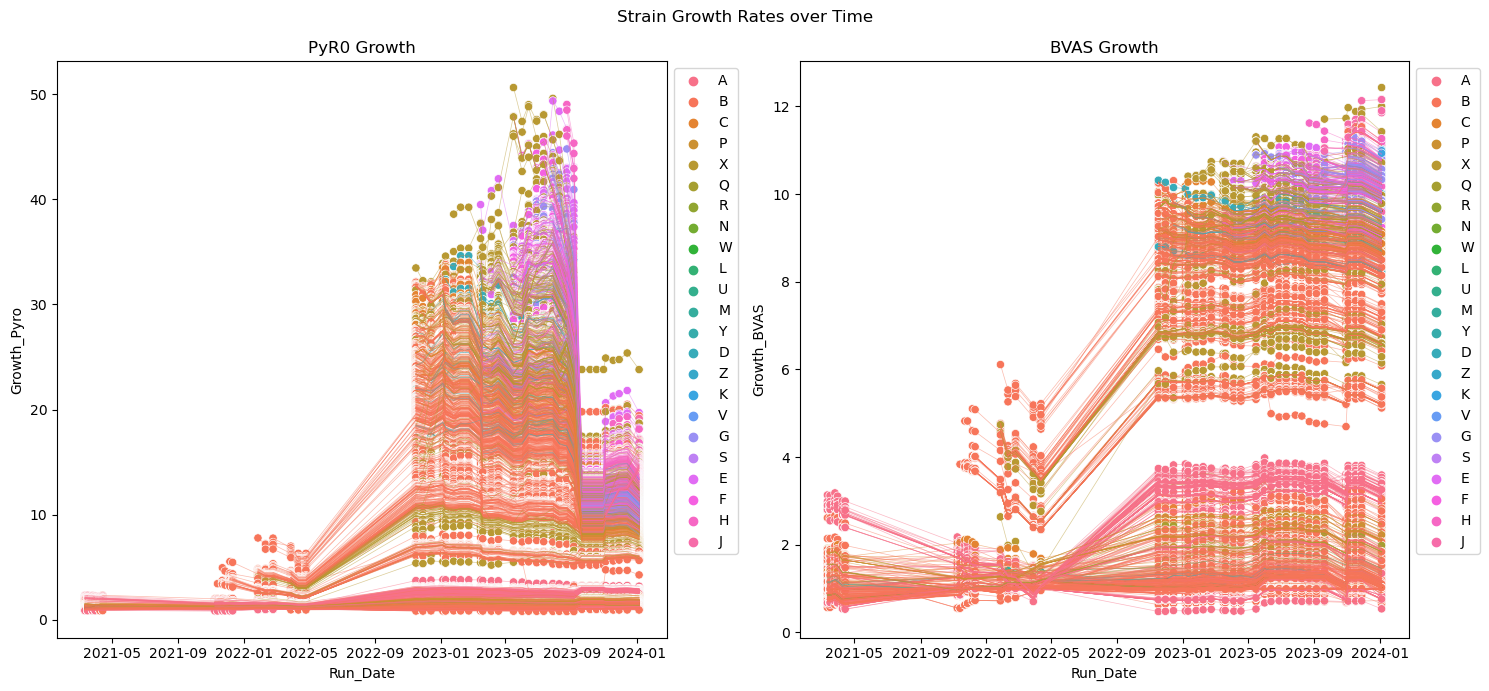

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.scatterplot(data=combined,
                x="Run_Date",
                y="Growth_Pyro",
                hue="Category",
                palette=category_palette,
                ax=ax[0])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Growth_Pyro",
                hue="Strain",
                palette=strain_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
#ax[0].set_ylim([max(combined["Rank_Pyro"]), -50])
ax[0].set_title("PyR0 Growth")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))


sns.scatterplot(data=combined,
                x="Run_Date",
                y="Growth_BVAS",
                hue="Category",
                palette=category_palette,
                ax=ax[1])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Growth_BVAS",
                hue="Strain",
                palette=strain_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
#ax[1].set_ylim([max(combined["Rank_BVAS"]), -50])
ax[1].set_title("BVAS Growth")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.suptitle("Strain Growth Rates over Time")
plt.tight_layout()

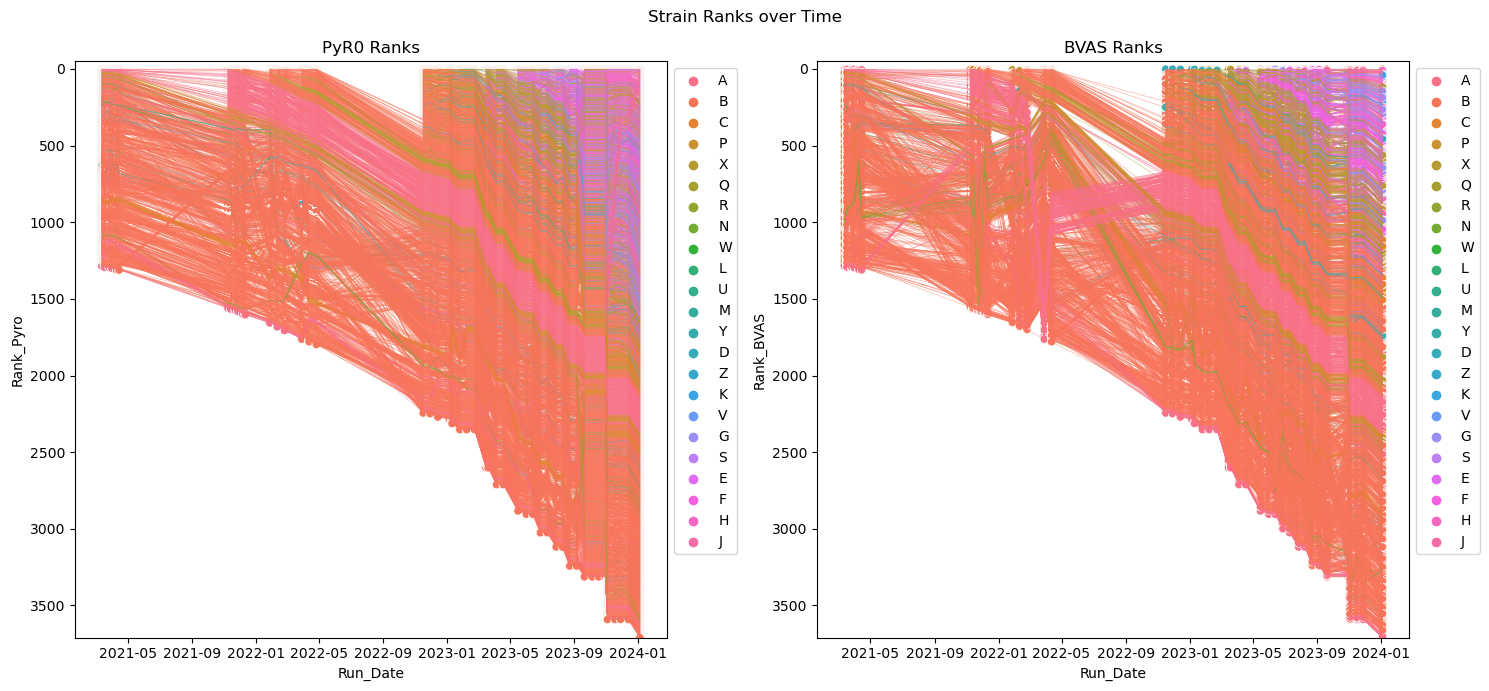

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.scatterplot(data=combined,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Category",
                palette=category_palette,
                ax=ax[0])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Strain",
                palette=strain_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
ax[0].set_ylim([max(combined["Rank_Pyro"]), -50])
ax[0].set_title("PyR0 Ranks")
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))


sns.scatterplot(data=combined,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Category",
                palette=category_palette,
                ax=ax[1])
sns.lineplot(data=combined,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Strain",
                palette=strain_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
ax[1].set_ylim([max(combined["Rank_BVAS"]), -50])
ax[1].set_title("BVAS Ranks")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.suptitle("Strain Ranks over Time")
plt.tight_layout()

In [20]:
combined

combined["AvgRank_Pyro"] = combined.groupby(["Category", "Run_Date"])["Rank_Pyro"].transform("mean")
combined["MaxRank_Pyro"] = combined.groupby(["Category", "Run_Date"])["Rank_Pyro"].transform("min")

combined["AvgRank_BVAS"] = combined.groupby(["Category", "Run_Date"])["Rank_BVAS"].transform("mean")
combined["MaxRank_BVAS"] = combined.groupby(["Category", "Run_Date"])["Rank_BVAS"].transform("min")

combined_reduced = combined[["Run_Date", "Category", "AvgRank_Pyro", "MaxRank_Pyro", "AvgRank_BVAS", "MaxRank_BVAS"]].drop_duplicates().reset_index(drop=True)

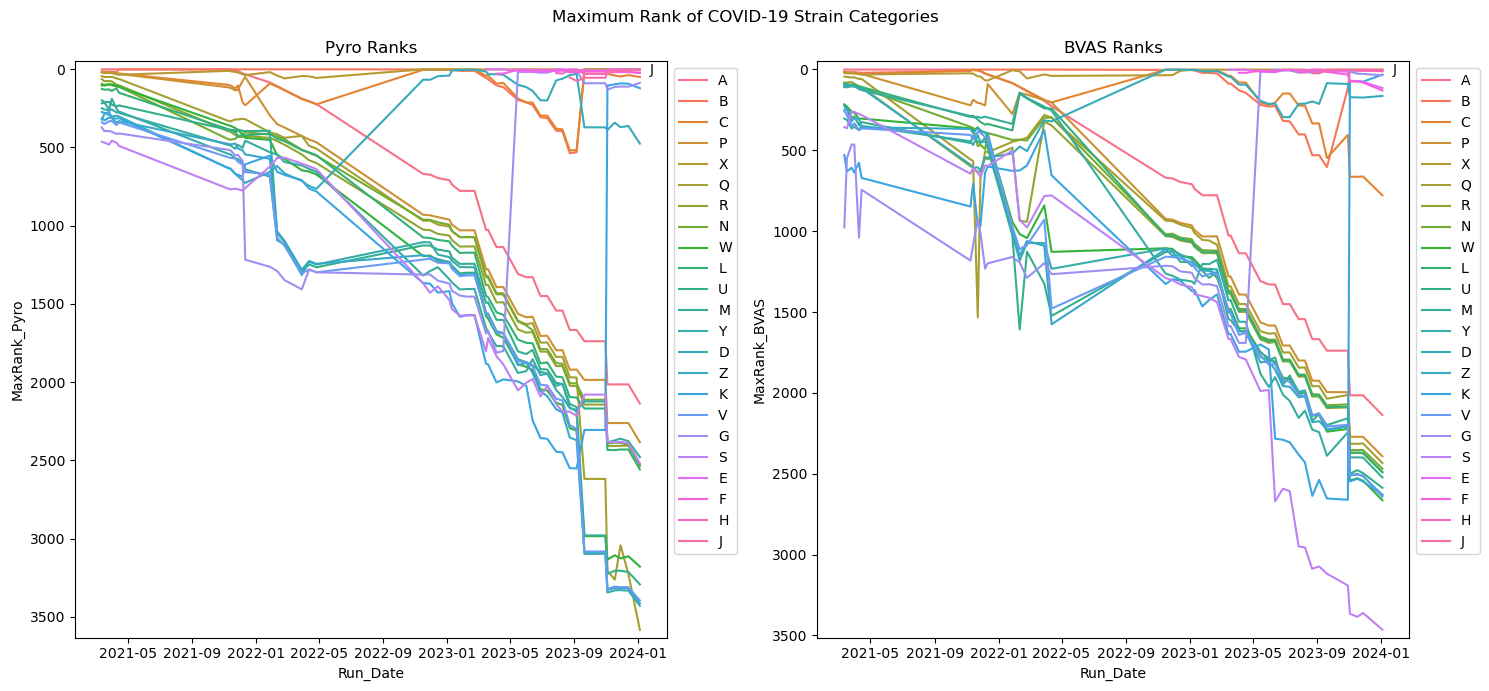

In [21]:

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "MaxRank_Pyro",
                hue = "Category",
                ax=ax[0])
ax[0].set_ylim([max(combined_reduced["MaxRank_Pyro"])+50, -50])
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_title("Pyro Ranks")

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "MaxRank_BVAS",
                hue = "Category",
                ax=ax[1])
ax[1].set_ylim([max(combined_reduced["MaxRank_BVAS"])+50, -50])
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_title("BVAS Ranks")

for index, row in combined_reduced.iterrows():
    if ((row['Run_Date']==max(combined_reduced['Run_Date']))&(row['Category']=='J')):
        ax[0].annotate(f'{row["Category"]}', (row['Run_Date'], row['MaxRank_Pyro']),
                       textcoords="offset points", xytext=(10, -3), ha='right')
        ax[1].annotate(f'{row["Category"]}', (row['Run_Date'], row['MaxRank_BVAS']),
                       textcoords="offset points", xytext=(10, -3), ha='right')

plt.suptitle("Maximum Rank of COVID-19 Strain Categories")
plt.tight_layout()

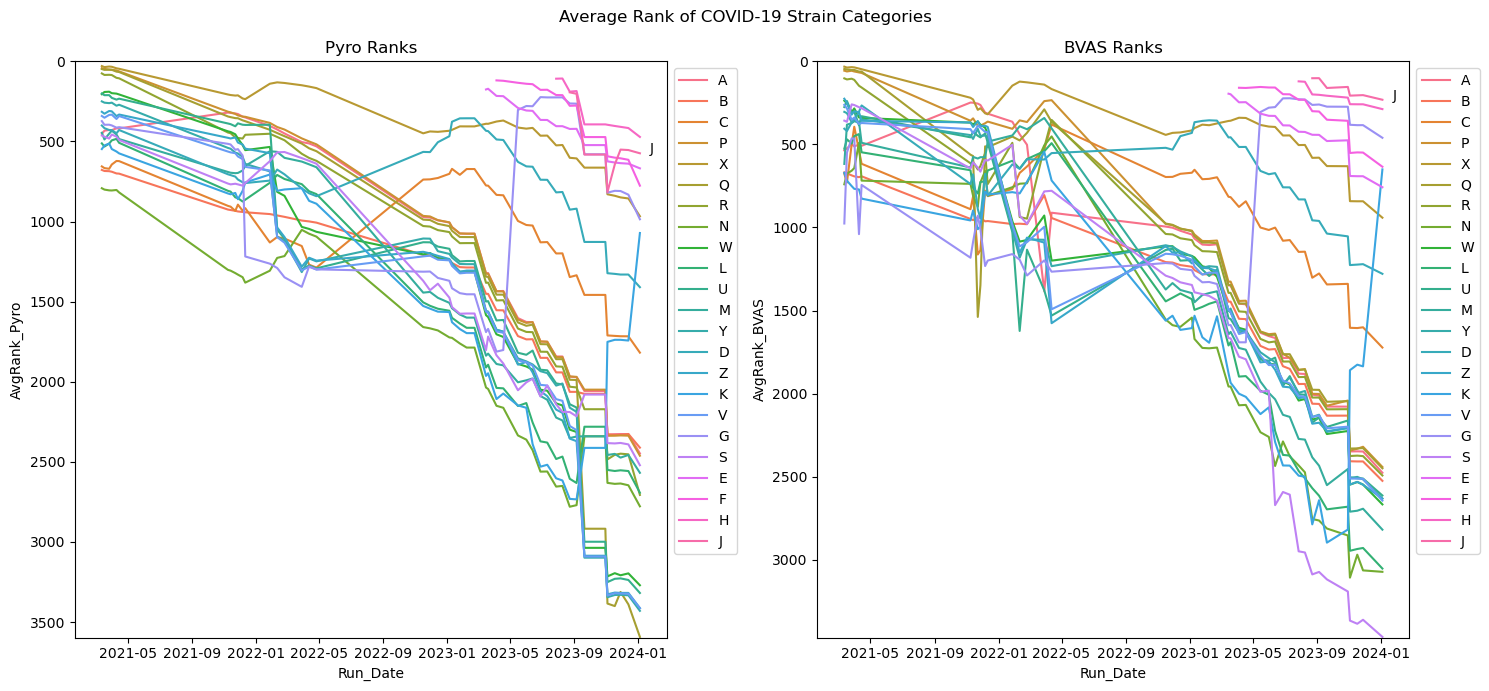

In [22]:

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "AvgRank_Pyro",
                hue = "Category",
                ax=ax[0])
ax[0].set_ylim([max(combined_reduced["AvgRank_Pyro"])+5, 0])
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_title("Pyro Ranks")

sns.lineplot(data = combined_reduced,
                x = "Run_Date",
                y = "AvgRank_BVAS",
                hue = "Category",
                ax=ax[1])
ax[1].set_ylim([max(combined_reduced["AvgRank_BVAS"])+5, 0])
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_title("BVAS Ranks")

for index, row in combined_reduced.iterrows():
    if ((row['Run_Date']==max(combined_reduced['Run_Date']))&(row['Category']=='J')):
        ax[0].annotate(f'{row["Category"]}', (row['Run_Date'], row['AvgRank_Pyro']),
                       textcoords="offset points", xytext=(10, 0), ha='right')
        ax[1].annotate(f'{row["Category"]}', (row['Run_Date'], row['AvgRank_BVAS']),
                       textcoords="offset points", xytext=(10, 0), ha='right')

plt.suptitle("Average Rank of COVID-19 Strain Categories")
plt.tight_layout()

In [23]:

combined_hits = combined[combined["Hits"]==1].reset_index(drop=True)
combined_hits

Run_Date  Strain  Growth_Pyro  Growth_BVAS  Rank_Pyro  Rank_BVAS Class  \
0    2021-03-12  AY.130      2.32119     3.133176        1.0        1.0    AY   
1    2021-03-12  AY.127      2.25726     2.983819        2.0        2.0    AY   
2    2021-03-12  AY.126      2.15747     2.901212        3.0        3.0    AY   
3    2021-03-12   AY.36      2.14965     2.896096        4.0        4.0    AY   
4    2021-03-17  AY.130      2.33253     3.120795        1.0        1.0    AY   
...         ...     ...          ...          ...        ...        ...   ...   
1608 2024-01-04  AY.127      2.82178     3.260985     2259.0     2159.0    AY   
1609 2024-01-04  AY.126      2.81194     3.189070     2269.0     2218.0    AY   
1610 2024-01-04   AY.36      2.79130     3.200685     2287.0     2185.0    AY   
1611 2024-01-04  AY.130      2.78262     3.327594     2293.0     2151.0    AY   
1612 2024-01-04   AY.43      2.67999     3.258115     2314.0     2168.0    AY   

     Category  Hits  AvgRank_Pyro  MaxRank_Pyro  AvgRank_BVAS  MaxRank_BVAS  
0           A     1    452.635417           1.0    536.515625           1.0  
1           A     1    452.635417           1.0    536.515625           1.0  
2           A     1    452.635417           1.0    536.515625           1.0  
3           A     1    452.635417           1.0    536.515625           1.0  
4           A     1    433.005051           1.0    523.727273           1.0  
...       ...   ...           ...           ...           ...           ...  
1608        A     1   2447.433535        2137.0   2476.081571        2137.0  
1609        A     1   2447.433535        2137.0   2476.081571        2137.0  
1610        A     1   2447.433535        2137.0   2476.081571        2137.0  
1611        A     1   2447.433535        2137.0   2476.081571        2137.0  
1612        A     1   2447.433535        2137.0   2476.081571        2137.0  

[1613 rows x 13 columns]

In [24]:
strain_correspondence = combined_hits[["Strain", "Class"]].drop_duplicates()
strain_class = dict(zip(strain_correspondence["Strain"], strain_correspondence["Class"]))
class_palette = dict(zip(combined_hits["Class"].unique(), sns.color_palette("husl",len(combined_hits["Class"].unique())).as_hex()))
strain_palette = {key_A: class_palette[value_B] for key_A, value_B in strain_class.items() if value_B in class_palette}

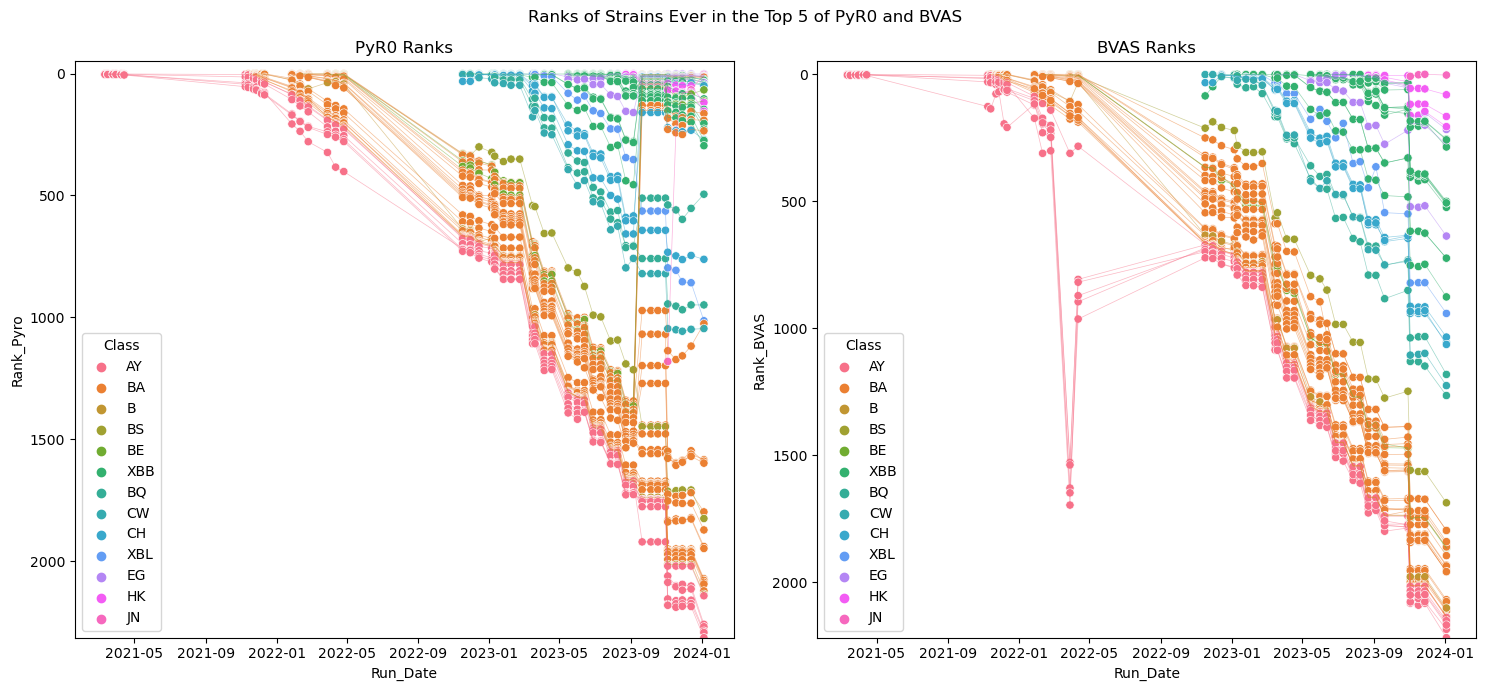

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sns.scatterplot(data=combined_hits,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Class",
                palette=class_palette,
                ax=ax[0])
sns.lineplot(data=combined_hits,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Strain",
                palette=strain_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
ax[0].set_ylim([max(combined_hits["Rank_Pyro"]), -50])
ax[0].set_title("PyR0 Ranks")

sns.scatterplot(data=combined_hits,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Class",
                palette=class_palette,
                ax=ax[1])
sns.lineplot(data=combined_hits,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Strain",
                palette=strain_palette,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
ax[1].set_ylim([max(combined_hits["Rank_BVAS"]), -50])
ax[1].set_title("BVAS Ranks")



plt.suptitle("Ranks of Strains Ever in the Top 5 of PyR0 and BVAS")
plt.tight_layout()

In [26]:
combined_10 = combined[(combined["Rank_BVAS"]<=10)|(combined["Rank_Pyro"]<=10)].copy()


strain_correspondence_10 = combined_10[["Strain", "Category"]].drop_duplicates()
strain_category_10 = dict(zip(strain_correspondence_10["Strain"], strain_correspondence_10["Category"]))
category_palette_10 = dict(zip(combined_10["Category"].unique(), sns.color_palette("husl",len(combined_10["Category"].unique())).as_hex()))
strain_palette_10 = {key_A: category_palette_10[value_B] for key_A, value_B in strain_category_10.items() if value_B in category_palette_10}

/Applications/anaconda3/envs/data_analysis_env/lib/python3.11/site-packages/seaborn/relational.py:414: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cis = grouped.apply(bootstrapped_cis)


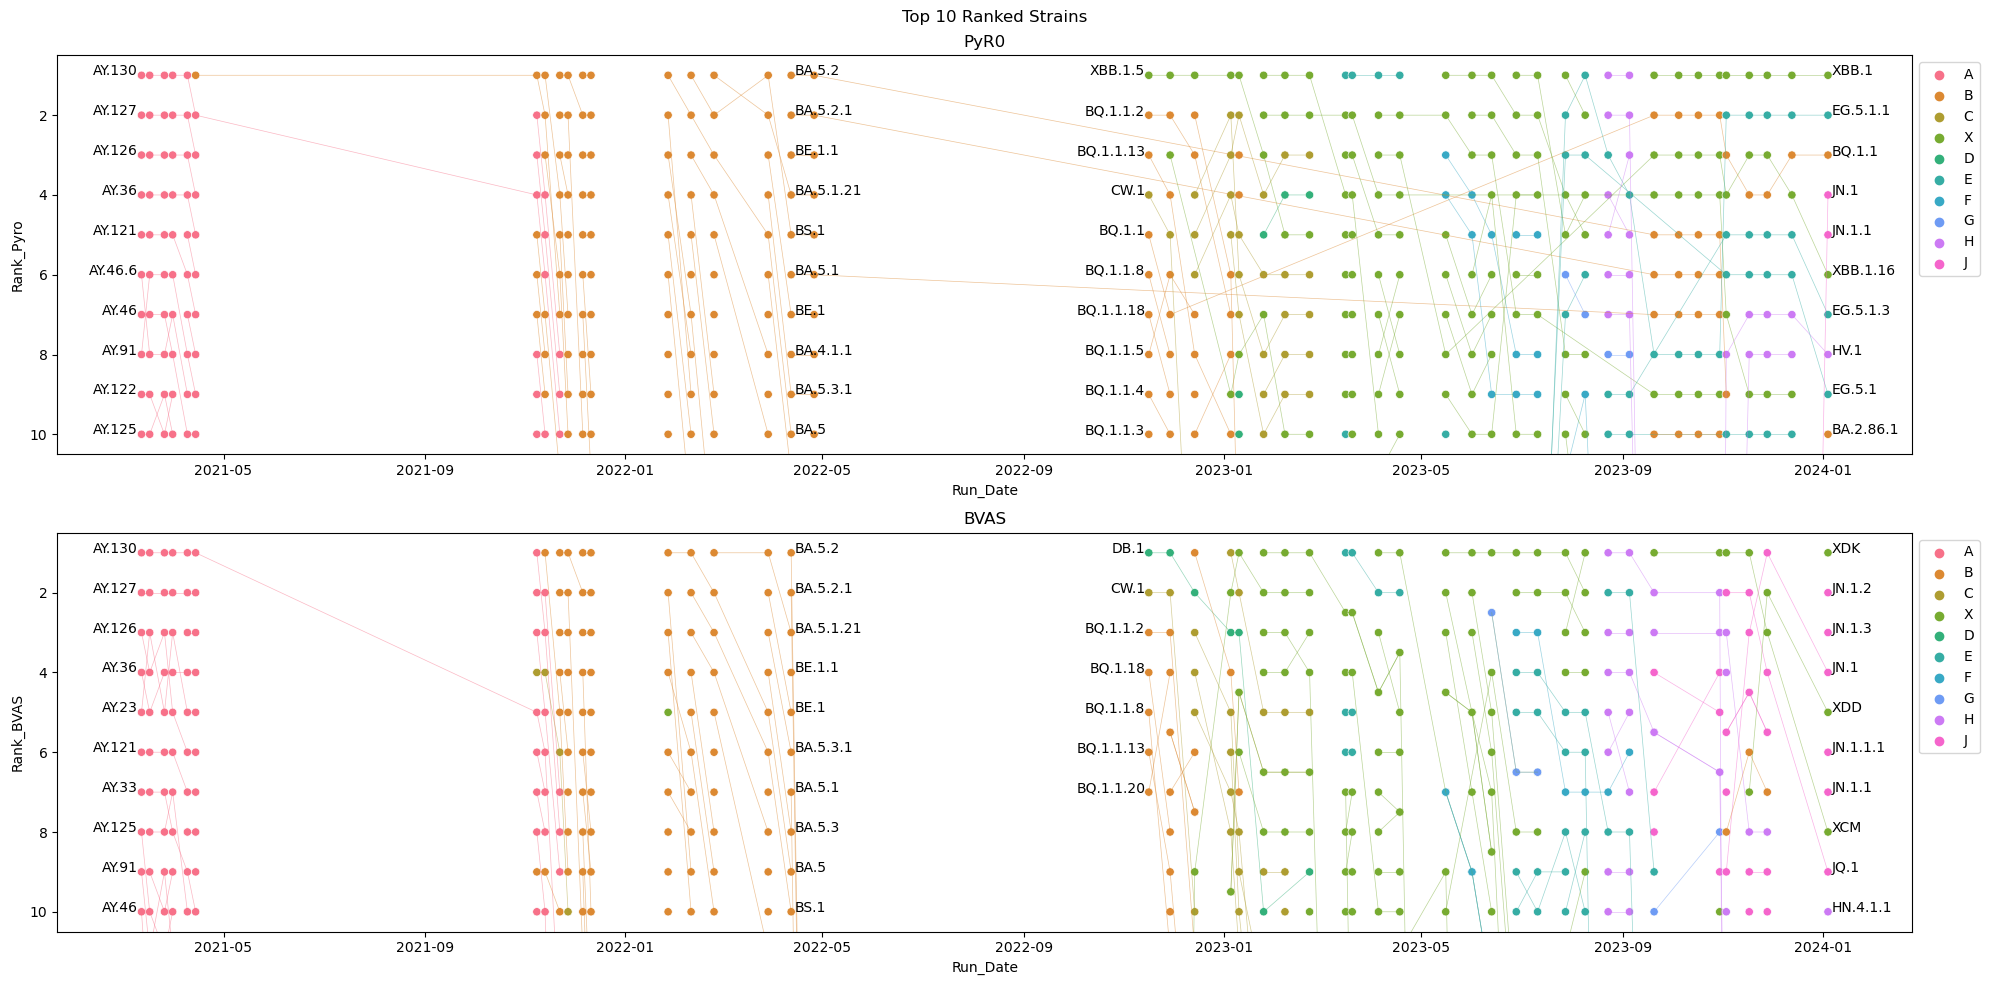

In [35]:
fig, ax = plt.subplots(nrows=2, figsize=(20,10))

sns.scatterplot(data=combined_10,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Category",
                palette=category_palette_10,
                ax=ax[0])
sns.lineplot(data=combined_10,
                x="Run_Date",
                y="Rank_Pyro",
                hue="Strain",
                palette=strain_palette_10,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[0])
ax[0].set_ylim([10.5, 0.5])
ax[0].set_title("PyR0")

for index, row in combined_10.iterrows():
    if (row['Run_Date']==min(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-11-16")):
        ax[0].annotate(f'{row["Strain"]}', (row['Run_Date'], row['Rank_Pyro']),
                    textcoords="offset points", xytext=(-2.5, 0), ha='right')
    if (row['Run_Date']==max(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-04-12")):
        ax[0].annotate(f'{row["Strain"]}', (row['Run_Date'], row['Rank_Pyro']),
                    textcoords="offset points", xytext=(2.5, 0), ha='left')
        
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.scatterplot(data=combined_10,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Category",
                palette=category_palette_10,
                ax=ax[1])
sns.lineplot(data=combined_10,
                x="Run_Date",
                y="Rank_BVAS",
                hue="Strain",
                palette=strain_palette_10,
                alpha=0.5,
                linewidth=0.5,
                legend=False,
                ax=ax[1])
ax[1].set_ylim([10.5, 0.5])
ax[1].set_title("BVAS")

for index, row in combined_10.iterrows():
    if (row['Run_Date']==min(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-11-16")):
        ax[1].annotate(f'{row["Strain"]}', (row['Run_Date'], row['Rank_BVAS']),
                    textcoords="offset points", xytext=(-2.5, 0), ha='right')
    if (row['Run_Date']==max(combined_10['Run_Date']))|(row['Run_Date']==pd.to_datetime("2022-04-12")):
        ax[1].annotate(f'{row["Strain"]}', (row['Run_Date'], row['Rank_BVAS']),
                    textcoords="offset points", xytext=(2.5, 0), ha='left')
        
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle("Top 10 Ranked Strains")
plt.tight_layout()


In [28]:
combined_10["Rank_BVAS"].corr(combined_10["Rank_Pyro"])

-0.06344408362665997

In [29]:
combined_hits["Rank_BVAS"].corr(combined_hits["Rank_Pyro"])

0.884778020402286

In [30]:
combined_hits["Growth_BVAS"].corr(combined_hits["Growth_Pyro"])

0.8302010732943419

In [31]:
combined["Rank_BVAS"].corr(combined["Rank_Pyro"])

0.9503320410734751

In [32]:
combined["Growth_BVAS"].corr(combined["Growth_Pyro"])

0.8893342908623046

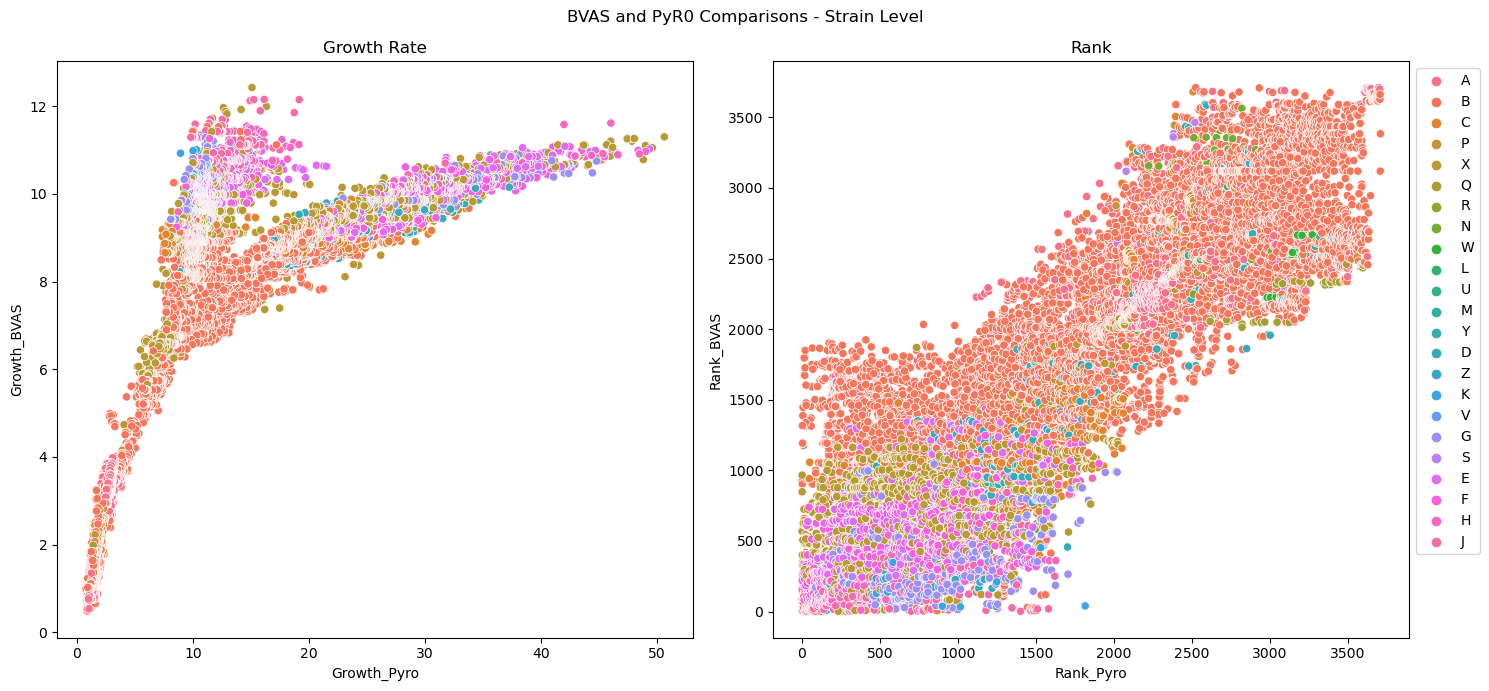

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
sns.scatterplot(data=combined,
                x="Growth_Pyro",
                y="Growth_BVAS",
                hue="Category",
                ax=ax[0],
                legend=False)
ax[0].set_title("Growth Rate")
sns.scatterplot(data=combined,
                x="Rank_Pyro",
                y="Rank_BVAS",
                hue="Category",
                ax=ax[1])
ax[1].set_title("Rank")
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle("BVAS and PyR0 Comparisons - Strain Level")
plt.tight_layout()
                